In [1]:
import lal, lalsimulation, numpy, copy
from pycbc.types import TimeSeries, FrequencySeries, zeros, Array
from pycbc.types import real_same_precision_as, complex_same_precision_as
import pycbc.scheme as _scheme
import inspect
from pycbc.fft import fft
from pycbc import pnutils
from pycbc.waveform import utils as wfutils
from pycbc.waveform import parameters
from pycbc.filter import interpolate_complex_frequency, resample_to_delta_t, match
import pycbc
import numpy as np
from six.moves import range as xrange

import pycbc.psd
import pycbc.noise
import pycbc.waveform
import pycbc.filter
import numpy as npd
import matplotlib.pyplot as plt

from pycbc.filter import matched_filter
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.pyplot as pl

from pycbc.psd import interpolate, inverse_spectrum_truncation

from pycbc.waveform import * #get_td_waveform, get_fd_waveform
import pylab
import h5py

In [2]:
def one_sided_planck_taper(e, n, N):
    if n == 0:
        return 0
    
    if n >= e * N:
        return 1
    
    z_plus = N * e * (1.0 / n + 1.0 / (n - e * N))
    
    if n < e * N:
        return 1.0 / (np.exp(z_plus) + 1.0)
    else:
        return 1.0

def apply_tapering(td_waveform, e):
    N = len(td_waveform)
    bound = int(e * N)-1
    tapered_waveform = td_waveform.copy()
    for n in range (0, bound):
        tapered_waveform[n] = one_sided_planck_taper(e, n, N) * td_waveform[n]
    return tapered_waveform

def derivative_interpolant(x, deriv_i, deriv_f, x_i, x_f):
    """Evaluates a quadratic function Q(x) determined by the value of its
    derivative at two locations. Note that this quadratic function is only
    determined up to a constant. 

    Parameters
    ----------
    x : float
        x-coordinate at which to evaluate the quadratic function Q.
    deriv_i : float
        value of the derivative of the quadratic function Q at x_i.
    deriv_f : float
        value of the derivative of the quadratic function Q at x_f.
    x_i : float
        x-coordinate such that Q'(x_i) = deriv_i
    x_f : float
        x-coordinate such that Q'(x_f) = deriv_f

    Returns
    -------
    q_x : float
        The quadratic function evaluated at x.
    """

    linear_term = (deriv_i * x_f - deriv_f * x_i) * x
    quadratic_term = 0.5 * (deriv_f - deriv_i) * x**2
    q_x = (quadratic_term + linear_term) / (x_f - x_i)
    return q_x

def ddeltaphidf_early_inspiral(f, total_mass, beta, b):
    """Evaluates the derivative of the phase change in the early inspiral with
    respect to the frequency at some frequency f. The phase change in the early
    inspiral is given by beta * v ** b, where v = (pi * total_mass * f) ** (1/3)
    The derivative is then given by beta * b * v ** (b-1) * dv/df, where dv/df
    is given by (1/3) * (pi * total_mass * f) ** (-2/3) * pi * total_mass,
    or (1/3) * v ** -2 * pi * total_mass.

    Parameters
    ----------
    f : float
        The frequency, in Hz, at which to evaluate the derivative.
    total_mass : float
        The total mass of the binary, in solar masses.
    beta : float
        The ppE parameter beta.
    b : float
        The ppE parameter b.

    Returns
    -------
    deriv : float
         The value of the derivative at the frequency f.
    """

    total_mass_in_seconds = total_mass * lal.MTSUN_SI
    v = pow(np.pi * total_mass_in_seconds * f, 1. / 3.)
    deriv = b * beta * np.pi * total_mass_in_seconds * pow(v, b - 3) / 3.0
    return deriv

def ddeltaphidf_late_inspiral(f, total_mass, epsilon):
    """Evaluates the derivative of the phase change in the late inspiral with
    respect to the frequency at some frequency f. The phase change in the late
    inspiral is given by epsilon * v, where v = (pi * total_mass * f) ** (1/3).
    The derivative is then given by epsilon * dv/df, where dv/df
    is given by (1/3) * (pi * total_mass * f) ** (-2/3) * pi * total_mass,
    or (1/3) * v ** -2 * pi * total_mass.

    Parameters
    ----------
    f : float
        The frequency, in Hz, at which to evaluate the derivative.
    total_mass : float
        The total mass of the binary, in solar masses.
    epsilon : float
        The ppE parameter epsilon.

    Returns
    -------
    deriv : float
         The value of the derivative at the frequency f.
    """

    total_mass_in_seconds = total_mass * lal.MTSUN_SI
    v = pow(np.pi * total_mass_in_seconds * f, 1. / 3.)
    deriv = epsilon * np.pi * total_mass_in_seconds * pow(v, -2) / 3.0
    return deriv

def light_ring_frequency_in_hz(total_mass):
    """The light ring frequency for a nonspinning BH. 

    Parameters
    ----------
    total_mass : float
        The total mass of the binary, in solar masses.

    Returns
    -------
    f_LR : float
         The light ring frequency, in Hz.
    """

    c = 2.998e8 # m/s
    GM_sun = 1.327e20 # m^3/s^2
    f_LR = c**3 / (6 * np.pi * GM_sun * total_mass)
    return f_LR

def ringdown_frequency(fd_waveform, total_mass):
    """Numerically finds the ringdown frequency, f_RD, given a frequency
    domain waveform. The ringdown frequency is as defined in:
    https://arxiv.org/pdf/1508.07253.pdf

    Parameters
    ----------
    fd_waveform : FrequencySeries
        The frequency domain waveform of the coalescence.
    total_mass : float
        The total mass of the binary, in solar masses.

    Returns
    -------
    f_RD : float
         The ringdown frequency, in Hz.
    """

    light_ring_index_array = np.where(fd_waveform.sample_frequencies.data \
      > light_ring_frequency_in_hz(total_mass))
    if(len(light_ring_index_array[0]) == 0):
        #Short approximant
        return 0.018 / lal.MTSUN_SI * total_mass
    light_ring_index = light_ring_index_array[0][0]
    four_times_light_ring_index = np.where(fd_waveform.sample_frequencies.data \
      > 2 * light_ring_frequency_in_hz(total_mass))[0][0]
    mindex = np.argmin(np.gradient(np.unwrap(np.angle( \
      fd_waveform.data[light_ring_index:four_times_light_ring_index]))))
    if(mindex == 0):
        #Short approximant
        return 0.018 / lal.MTSUN_SI * total_mass
    f_RD = fd_waveform.sample_frequencies[mindex + light_ring_index]
    return f_RD

def apply_ppe_correction(fd_waveform, total_mass, beta, b, f_lower, epsilon, delta_f):
    """Applies the parameterized post-Einsteinian corrections to a waveform
    in the frequency domain such that the derivative of the phase is continuous
    across the different frequency regimes, where a different correction is
    applied in each one. These frequency regimes are:
    * Up to f_low:
    No correction is applied. The waveform is only defined above
    the frequency f_low, so the content contained in frequencies below f_low
    are unphysical.
    * Between f_low and Mf = 0.018:
    The beta-ppe correction is applied, to the phase through
    delta phi = beta * v ^ b, where v = (pi * M * f) ^ (1 / 3).
    * Between Mf = 0.018 and f = 0.75f_RD, the ringdown frequency:
    The epsilon-ppe correction is applied, also to the phase, through
    delta phi = epsilon * v.
    * After f = 0.75f_RD, no correction is applied.

    In between these four frequency ranges, we also have three transition
    regions across which the derivatives of the four ranges are matched at
    each end. The width of this transition region is set by delta_f.

    Parameters
    ----------
    fd_waveform : FrequencySeries
        The frequency domain waveform of the coalescence.
    total_mass : float
        The total mass of the binary, in solar masses.
    beta : float
        The ppE parameter beta.
    b : float
        The ppE parameter b.
    f_lower : float
        The frequency at which the physical waveform begins. The content of
        the waveform below this frequency is unphysical.
    epsilon : float
        The ppE parameter epsilon.
    delta_f : float
        The width of the transition region between each frequency regime.

    Returns
    -------
    new_fd_waveform : FrequencySeries
         The frequency domain waveform of the coalescence, after applying
         the ppE corrections.
    """

    total_mass_in_seconds = total_mass * lal.MTSUN_SI
    pi_M = np.pi * total_mass_in_seconds
    new_fd_waveform = fd_waveform.copy()
    #  Defines up to where to apply the beta-ppe correction as well as up
    #  to where to apply the epsilon-ppe correction.
    freq_IM_begin = 0.018 / total_mass_in_seconds
    freq_IM_end = 0.75 * ringdown_frequency(fd_waveform, total_mass)

    #  Defines the boundaries of the transition regions:
    #  Transition region between No Correction and Beta Correction:
    f_1 = f_lower - 0.5 * delta_f
    f_2 = f_lower + 0.5 * delta_f
    #  Transition region between Beta Correction and Epsilon Correction:
    f_3 = freq_IM_begin - 0.5 * delta_f
    f_4 = freq_IM_begin + 0.5 * delta_f
    #  Transition region between Epsilon Correction and Constant Correction:
    f_5 = freq_IM_end - 0.5 * delta_f
    f_6 = freq_IM_end + 0.5 * delta_f

    #  The values of the derivatives of the phase change at each endpoint of
    #  the transition region. The derivative is then linearly interpolated
    #  across the transition region using the `derivative_interpolant`, which
    #  returns the integral of the linear interpolant, which is the phase
    #  change itself.
    ddelphidf_1 = 0.0
    ddelphidf_2 = ddeltaphidf_early_inspiral(f_2, total_mass, beta, b)
    ddelphidf_3 = ddeltaphidf_early_inspiral(f_3, total_mass, beta, b)
    ddelphidf_4 = ddeltaphidf_late_inspiral(f_4, total_mass, epsilon)
    ddelphidf_5 = ddeltaphidf_late_inspiral(f_5, total_mass, epsilon)
    ddelphidf_6 = 0.0

    #  As `derivative_interpolant` returns an integral, it is only defined up
    #  to a constant. The accumulated phase change must separately be kept
    #  track of, such that the phase change is continuous across the different
    #  frequency ranges, as well as the derivative of the phase change.
    delphi_1 = derivative_interpolant(f_1, ddelphidf_1, ddelphidf_2, f_1, f_2)
    delphi_2 = derivative_interpolant(f_2, ddelphidf_1, ddelphidf_2, f_1, f_2)
    delphi_3 = derivative_interpolant(f_3, ddelphidf_3, ddelphidf_4, f_3, f_4)
    delphi_4 = derivative_interpolant(f_4, ddelphidf_3, ddelphidf_4, f_3, f_4)
    delphi_5 = derivative_interpolant(f_5, ddelphidf_5, ddelphidf_6, f_5, f_6)
    delphi_6 = derivative_interpolant(f_6, ddelphidf_5, ddelphidf_6, f_5, f_6)

    #  The accumulated phase change across the frequency ranges:
    phase_change_1 = -delphi_1
    phase_change_2 = delphi_2 + phase_change_1 - beta * pow(pi_M*f_2, b/3.)
    phase_change_3 = -delphi_3 + phase_change_2 + beta * pow(pi_M*f_3, b/3.)
    phase_change_4 = delphi_4 + phase_change_3 - epsilon * pow(pi_M*f_4,  1/3.)
    phase_change_5 = -delphi_5 + phase_change_4 + epsilon * pow(pi_M*f_5, 1/3.)
    phase_change_6 = delphi_6 + phase_change_5
    
    #Frequency indices
    freqs = np.array(new_fd_waveform.sample_frequencies.data)
    i_1 = np.searchsorted(freqs, f_1)
    i_2 = np.searchsorted(freqs, f_2)
    i_3 = np.searchsorted(freqs, f_3)
    i_4 = np.searchsorted(freqs, f_4)
    i_5 = np.searchsorted(freqs, f_5)
    i_6 = np.searchsorted(freqs, f_6)

    # Apply the ppE correction over the various ranges:
    vels = pow(pi_M * freqs, 1.0/3.0)
    phase_correction = np.ones_like(freqs, dtype=complex)

    # Transition from No Correction to Beta Correction:
    phase_change = \
        derivative_interpolant(freqs[i_1:i_2], ddelphidf_1, ddelphidf_2, f_1, f_2)
    phase_correction[i_1:i_2] = np.exp((phase_change + phase_change_1) * 1j)

    #  Apply Beta Correction:
    phase_change = beta * pow(vels[i_2:i_3], b)
    phase_correction[i_2:i_3] = np.exp((phase_change + phase_change_2) * 1j)

    # Transition from Beta Correction to Epsilon Correction:
    phase_change = \
        derivative_interpolant(freqs[i_3:i_4], ddelphidf_3, ddelphidf_4, f_3, f_4)
    phase_correction[i_3:i_4] = np.exp((phase_change + phase_change_3) * 1j)

    #  Apply Epsilon Correction:
    phase_change = epsilon * vels[i_4:i_5]
    phase_correction[i_4:i_5] = np.exp((phase_change + phase_change_4) * 1j)

    # Transition from Epsilon Correction to Constant Correction:
    phase_change = \
        derivative_interpolant(freqs[i_5:i_6], ddelphidf_5, ddelphidf_6, f_5, f_6)
    phase_correction[i_5:i_6] = np.exp((phase_change + phase_change_5) * 1j)

    # Apply Constant Correction:
    phase_correction[i_6:] = np.exp(phase_change_6 * 1j)

    new_fd_waveform.data = new_fd_waveform.data * phase_correction

    return new_fd_waveform

In [3]:
import numpy as np
from numpy import unravel_index
injection_file = h5py.File(name="/home/gabriel.bonilla/parameter_estimation/simple_injections/attempt_14_ppe_on_gr_imrphenomd_or/ppe_inference_test_14.hdf")
ells = injection_file['samples']['loglikelihood']
index = unravel_index(np.argmax(ells), np.shape(ells))
samples = injection_file['samples']
coa_phase = samples['coa_phase'][index]
mass1 = samples['mass1'][index]
mass2 = samples['mass2'][index]
ppe_beta = samples['ppe_beta'][index]
tc = samples['tc'][index]

/cvmfs/oasis.opensciencegrid.org/ligo/deploy/sw/pycbc/x86_64_rhel_7/virtualenv/pycbc-v1.18.3/lib/python2.7/site-packages/ipykernel/__main__.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()


In [4]:
mass1

31.173871109314497

In [5]:
mass2

28.906944585938316

In [6]:
ppe_beta

0.6493721837751365

(1e-26, 1e-19)

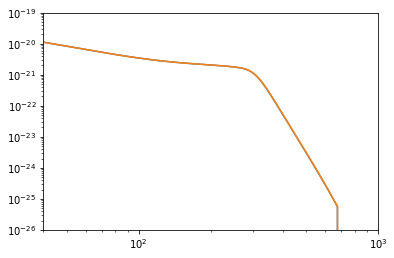

In [7]:
time_buffer = 16
sample_rate = 2048
tlen = sample_rate * time_buffer
flen = tlen / 2 + 1
delta_t = 1.0 / sample_rate
delta_f = 1.0 / time_buffer
f_lower = 20.0

hptilde, hctilde = get_fd_waveform(approximant="IMRPhenomD",
                    mass1=mass1,
                    mass2=mass2,
                    delta_f = delta_f,
                    f_lower=f_lower,
                    ra = 2.2,
                    dec = -1.25,
                    inclination = 2.5,
                    coa_phase = 1.5,
                    polarization = 1.75,
                    #distance = 100,
                    f_ref = 20)

hptilde0, hctilde0 = get_fd_waveform(approximant="IMRPhenomD",
                    mass1=30,
                    mass2=30,
                    delta_f = delta_f,
                    f_lower=f_lower,
                    ra = 2.2,
                    dec = -1.25,
                    inclination = 2.5,
                    coa_phase = 1.5,
                    polarization = 1.75,
                    #distance = 100,
                    f_ref = 20)

plt.plot(hptilde.sample_frequencies,np.abs(hptilde.data))
plt.plot(hptilde0.sample_frequencies,np.abs(hptilde0.data))
plt.semilogx()
plt.semilogy()
plt.xlim(40,1000)
plt.ylim(1e-26,1e-19)

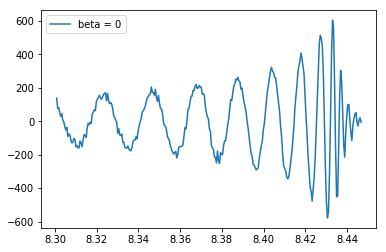

In [8]:
array_inj = injection_file["data"]["H1"]["stilde"][:]
flen = len(array_inj)
tlen = 2*(flen - 1)
delta_t = 1.0/2048.0
fs_inj = FrequencySeries(array_inj,delta_f=1.0/(tlen*delta_t))
ts_inj = fs_inj.to_timeseries()

plt.plot(ts_inj.sample_times[17000:17300],ts_inj[17000:17300],label="beta = 0")
plt.legend()

(0.01, 100.0)

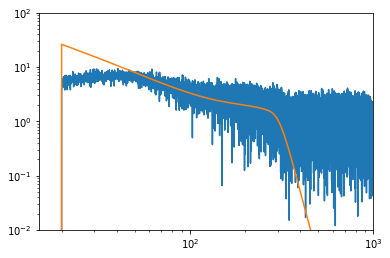

In [9]:
plt.plot(fs_inj.sample_frequencies, np.abs(fs_inj.data))
plt.plot(hptilde.sample_frequencies,np.abs(fs_inj.data[2000])/np.abs(hptilde.data[2000])*np.abs(hptilde.data))
plt.semilogy()
plt.semilogx()
plt.xlim(15,1000)
plt.ylim(1e-2,1e2)

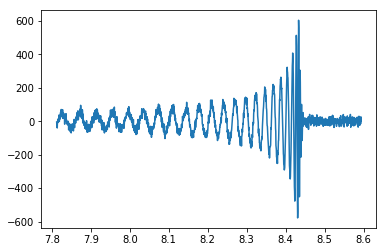

In [10]:
plt.plot(ts_inj.sample_times[16000:17600],ts_inj[16000:17600],label="beta = 0")

In [11]:
hptilde_corrected = apply_ppe_correction(fd_waveform = hptilde, total_mass=mass1+mass2, beta=ppe_beta, b=1.0, f_lower=f_lower, epsilon=0.0, delta_f=5.0)
hptilde_correctedn = apply_ppe_correction(fd_waveform = hptilde, total_mass=mass1+mass2, beta=-ppe_beta, b=1.0, f_lower=f_lower, epsilon=0.0, delta_f=5.0)


(1e-26, 1e-19)

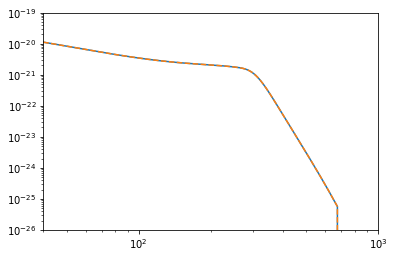

In [12]:
plt.plot(hptilde.sample_frequencies,np.abs(hptilde.data))
plt.plot(hptilde_corrected.sample_frequencies,np.abs(hptilde.data),ls="--")
plt.semilogx()
plt.semilogy()
plt.xlim(40,1000)
plt.ylim(1e-26,1e-19)

(0.01, 0.02)

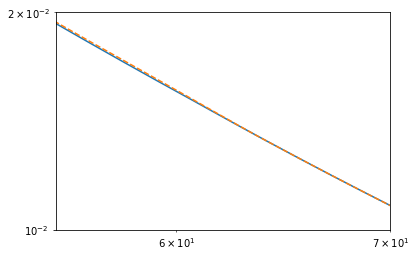

In [13]:
plt.plot(hptilde.sample_frequencies, np.gradient(np.unwrap(np.angle(hptilde))))
plt.plot(hptilde.sample_frequencies, np.gradient(np.unwrap(np.angle(hptilde_corrected))),ls="--")
plt.semilogy()
plt.semilogx()
plt.xlim(55,70)
plt.ylim(1e-2,2e-2)

In [14]:
ppe_beta

0.6493721837751365

In [15]:
inner_product = match(hptilde, hptilde_corrected,low_frequency_cutoff=f_lower)[0]

In [16]:
inner_product

0.999633844772895

In [17]:
import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
time_buffer = 16
sample_rate = 2048
tlen = sample_rate * time_buffer
flen = tlen / 2 + 1
delta_t = 1.0 / sample_rate
delta_f = 1.0 / time_buffer
f_lower = 20.0
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_lower)

In [18]:
template = hptilde_corrected
templaten = hptilde_correctedn
template0 = hptilde0
conditioned = fs_inj

snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=f_lower)
snrn = matched_filter(templaten, conditioned, psd=psd, low_frequency_cutoff=f_lower)
snr0 = matched_filter(template0, conditioned, psd=psd, low_frequency_cutoff=f_lower)
#snra = matched_filter(template0, conditioned, psd=psd, low_frequency_cutoff=f_lower)

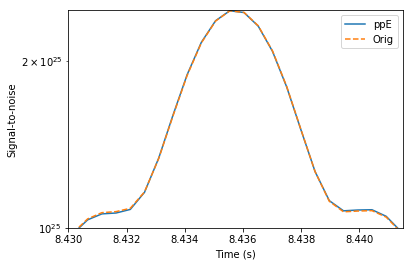

In [19]:
pl.plot(snr.sample_times, abs(snr), label = "ppE")
pl.plot(snr0.sample_times, abs(snr0), label = "Orig", ls = "--")
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.legend()
pl.xlim(8.43,8.4415)
pl.ylim(1.e25,2.47e25)
pl.semilogy()
pl.show()

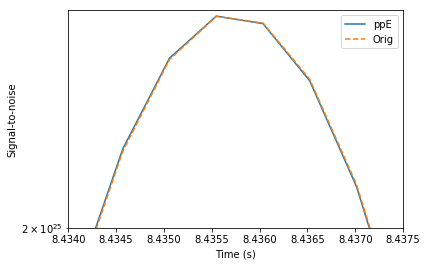

In [20]:
pl.plot(snr.sample_times, abs(snr), label = "ppE")
pl.plot(snr0.sample_times, abs(snr0), label = "Orig", ls = "--")
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.legend()
pl.xlim(8.434,8.4375)
pl.ylim(2.e25,2.48e25)
pl.semilogy()
pl.show()

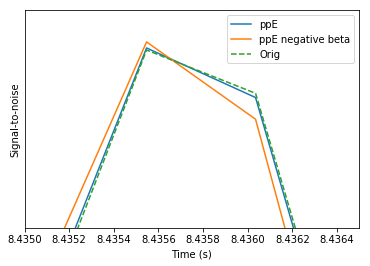

In [21]:
pl.plot(snr.sample_times, abs(snr), label = "ppE")
pl.plot(snrn.sample_times, abs(snrn), label = "ppE negative beta")
pl.plot(snr0.sample_times, abs(snr0), label = "Orig", ls = "--")
pl.ylabel('Signal-to-noise')
pl.xlabel('Time (s)')
pl.legend()
pl.xlim(8.435,8.4365)
pl.ylim(2.4e25,2.48e25)
pl.semilogy()
pl.show()

In [22]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("There is a signal at {}s with SNR {}".format(time, abs(snrp)))

There is a signal at 8.435546875s with SNR 2.46597394212e+25


In [23]:
peak0 = abs(snr0).numpy().argmax()
snrp0 = snr0[peak0]
time0 = snr0.sample_times[peak0]
print("There is a signal at {}s with SNR {}".format(time0, abs(snrp0)))

There is a signal at 8.435546875s with SNR 2.46519573412e+25


In [24]:
peakn = abs(snrn).numpy().argmax()
snrpn = snrn[peak]
timen = snrn.sample_times[peakn]
print("There is a signal at {}s with SNR {}".format(timen, abs(snrpn)))

There is a signal at 8.435546875s with SNR 2.46822673608e+25
